# Part 2 - House prices

Data cleaning
---
Your analysis should include the necessary data cleaning steps. For instance

- Find and handle incorrect, missing values
- Correct inconsistencies in the variables
- Handle outliers

You are free to choose your preferred approach to handle each step. For instance, you might want to replace missing values with the average or the most frequent value or create an missing category. In any case, justify your choices!

You can find a detailed description of each variable in the ``documentation.txt file``, but there are a few things to know.

- The ``Order`` and ``PID`` variables are identifiers. They are not useful to predict house prices.
- The variables are not necessarily encoded consistently. For instance, ``MS SubClass`` (the type of dwelling) and ``MS Zoning`` (zoning classification) are both categorical variables, but one is encoded with numerical values and the other with short labels.
- The data isn’t clean: there are incorrect and missing values, outliers and inconsistencies

You should address all these issues during the data cleaning stage.

In [408]:
# import libraries 
%matplotlib inline
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import re

In [409]:
# Load data train/test 
train_df = pd.read_csv("house-prices.csv")

# Display the first 5 rows of data train
train_df.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0    484  528275070           60        RL           NaN      8795   Pave   
1   2586  535305120           20        RL          75.0     10170   Pave   
2   2289  923228250          160        RM          21.0      2001   Pave   
3    142  535152150           20        RL          70.0     10552   Pave   
4   2042  903475060          190        RM          60.0     10120   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
2   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
3   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Bnk  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       4    2009       WD           Normal     236000  
1        0       6    2006       WD           Normal     155000  
2        0       1    2007       WD           Normal      75000  
3        0       4    2010       WD           Normal     165500  
4        0       1    2007       WD           Normal     122000  

[5 rows x 82 columns]

In [410]:
# Show size of the dataset
train_df.shape

(2430, 82)

In [411]:
# Count how many times each data type is present in the dataset
pd.value_counts(train_df.dtypes)

object     43
int64      28
float64    11
dtype: int64

In [412]:
# Check for duplicated values
train_df.duplicated().sum()

0

The ``Order`` and ``PID`` variables are identifiers. They are not useful to predict house prices. I will drop them

In [413]:
# Drop Order and PID variable 
train_df = train_df.drop(["Order", "PID"], axis=1)

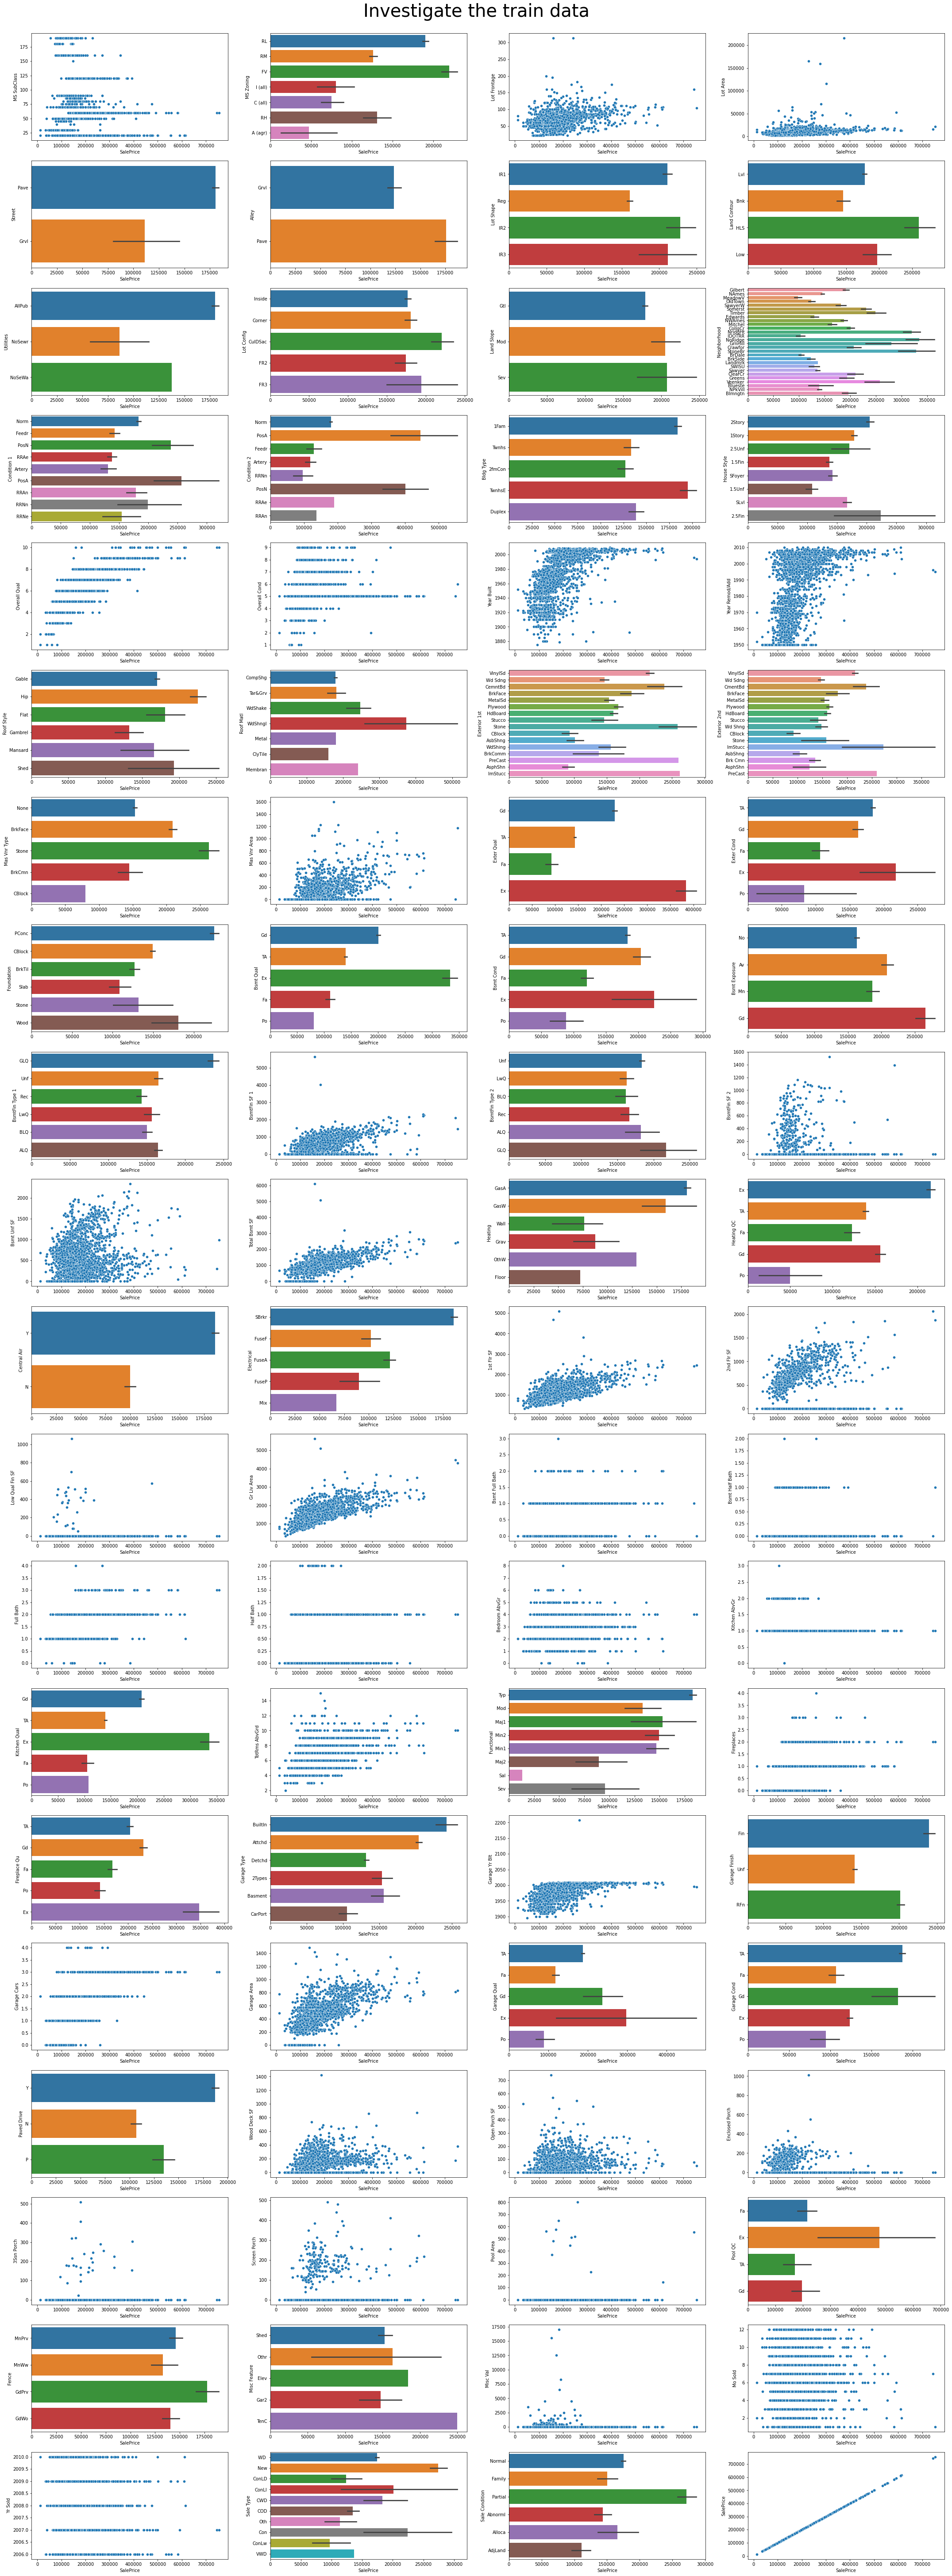

In [414]:
# Plot all the data
fig, axes = plt.subplots(round(len(train_df.columns)/4), 4, figsize=(30, 80))

for col, ax in zip(train_df.columns, axes.ravel()):
    if train_df[col].dtype in [np.int64, np.float64]:
        sns.scatterplot(data=train_df, y=col, x="SalePrice", ax=ax)
    else:
        # sns.barplot() will show the average value of the target variable for each category in the non-numerical column.
        sns.barplot(data=train_df, y=col, x="SalePrice", ax=ax)

plt.tight_layout()
plt.suptitle("Investigate the train data", fontsize=40, y=1.01)
plt.show()

### Investigate the percentage of missing values per feature. 

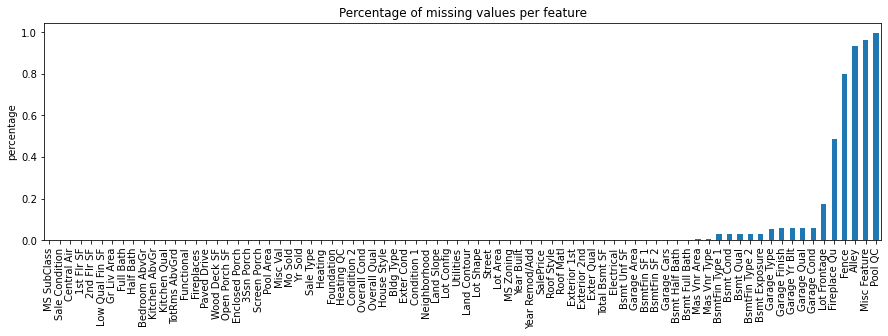

In [415]:
# Investigate the percentage of missing values per feature. 
train_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature")
plt.ylabel("percentage")
plt.show()

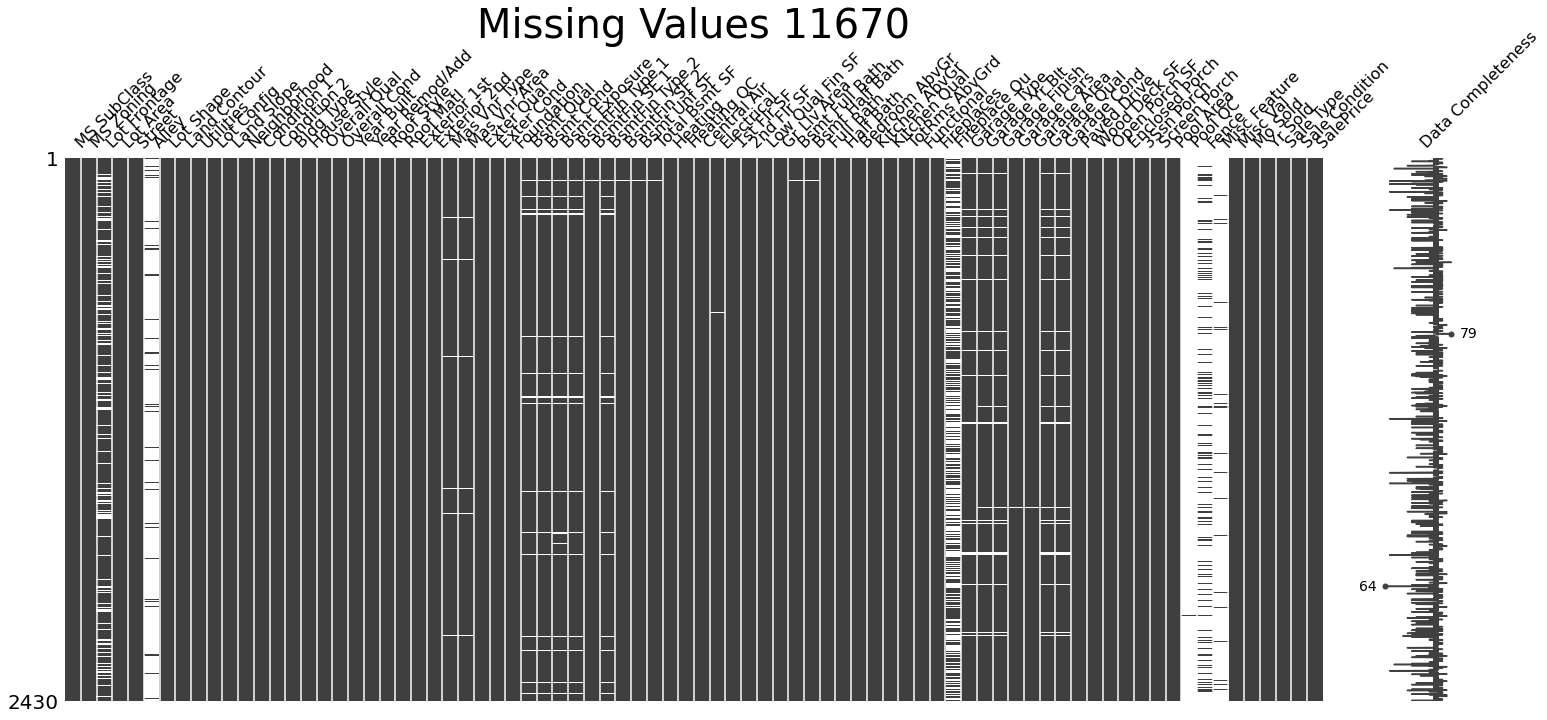

In [416]:
import missingno as msno
# Using msno.matrix() to see more details
msno.matrix(train_df, labels=True)
plt.title("Missing Values {}".format(train_df.isna().sum().sum()), fontsize=40)
plt.show()

We have 11670 missing values by checking the documentation we see 4 categories of variables nominal, ordinal, discrete and continuous. I will deal with missing values in each category separately. 

Steps:
1. Find the label that matches the variables and save them in a separate list.
2. Encode ordinal variable so I can deal with missing values and prepare the data for the modelling part.
3. I will check each category separately so I can deal with missing values by filling or dropping them.


In [417]:
# Search in the documentation the labels of each variable 

# Find the label that matches the variables 
def find_col_types(text):
    types = ["Nominal", "Ordinal", "Discrete",]
    pattern = r"(.*)\((Nominal|Ordinal|Discrete|Continuous)\):"
    matches = re.findall(pattern, text)
    # Save results in a dictionary 
    return {col.strip(): typ.strip() for col, typ in matches}

# Read txt file
with open('documentation.txt', 'r',  encoding='ISO-8859-1') as file:
    text = file.read()
    types = find_col_types(text)


In [418]:
# Save variables corresponding to the labels
col_normal = []

col_ordinal = []

col_discrete = []

col_continuous = []

remove_items = {
    "Nominal": ['Exterior 1', 'Exterior 2', 'PID'],
    "Ordinal": ['HeatingQC', 'KitchenQual'],
    "Discrete": ['Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Order'],
    "Continuous": ['3-Ssn Porch']
}

col_types = {
    "Nominal": col_normal, 
    "Ordinal": col_ordinal, 
    "Discrete": col_discrete, 
    "Continuous": col_continuous}


# Save labels in dictionary
for col, value in types.items():
    for type_name, columns in col_types.items():
        if value == type_name:
            columns.append(col)


# Remove column not find in the data
for type_name, columns in col_types.items():
    items_remove = remove_items.get(type_name)
    # Check if items
    if items_remove:
        for item in items_remove:
            # Check if item is in columns
            if item in columns:
                columns.remove(item)

# Adding a space to "BsmtFinType 2" and "FireplaceQu"
col_ordinal = list(map(lambda col: col.replace("BsmtFinType 2", "BsmtFin Type 2").replace("FireplaceQu", "Fireplace Qu"), col_ordinal))


for type_name, columns in col_types.items():
    print(f"{type_name} columns: {len(columns)}")

Nominal columns: 21
Ordinal columns: 21
Discrete columns: 11
Continuous columns: 18


- An important goal of the EDA is understand the relationship between our features and the target. Scatter plots and violin plots are a great way to visually explore this relationship for continuous respectively categorical features, as they allow us to discover patterns, identify suitable features or discover problems with the data, like outliers. This particular approach appears to be missing in your exploration.

### Investigate the relationship between continuous features and the target value

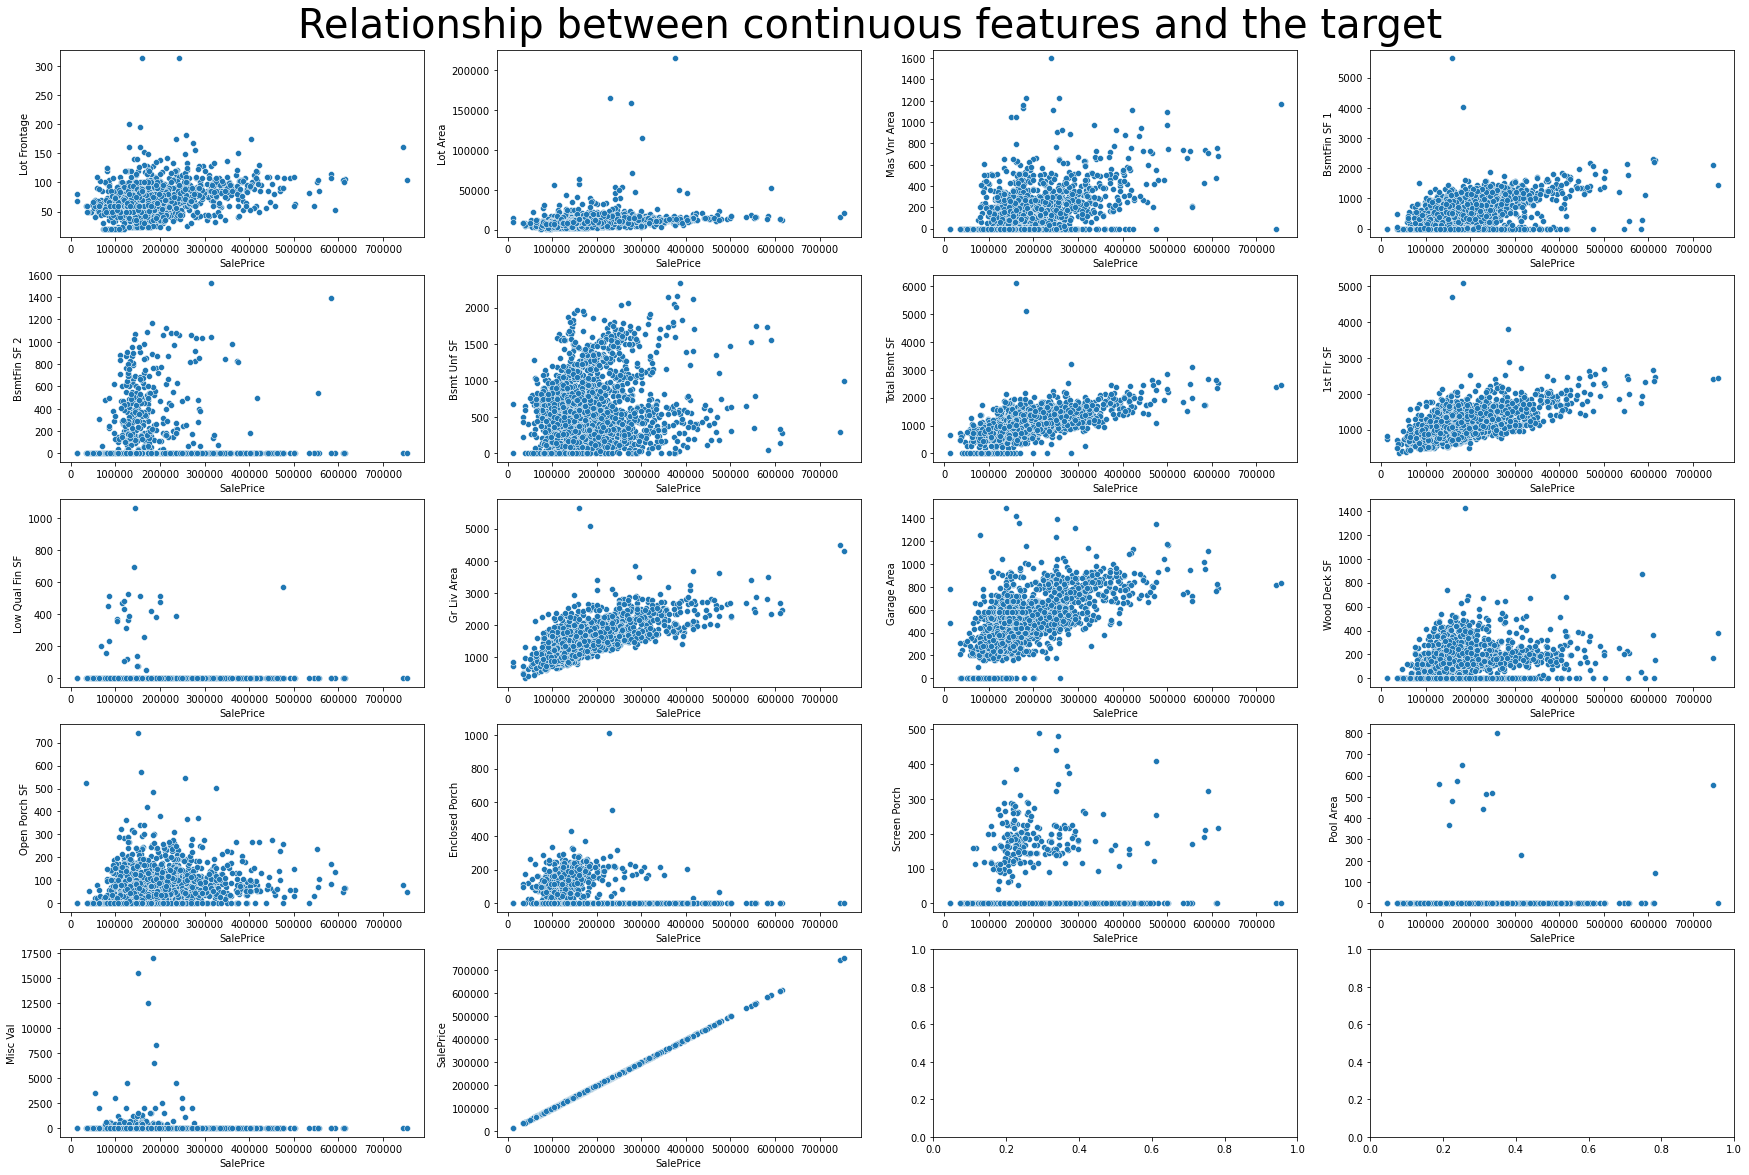

In [419]:
# Plot
fig, axes = plt.subplots(5, 4, figsize=(30, 20))

for col, ax in zip(train_df[col_continuous].columns, axes.ravel()):
    sns.scatterplot(data=train_df, y=col, x="SalePrice", ax=ax)

plt.suptitle("Relationship between continuous features and the target", fontsize=40, y=0.91)
plt.show()

We see outliers I will deal with them later. First I will clean the data to remove NaN values. 

### Investigate the percentage of missing values per feature. 

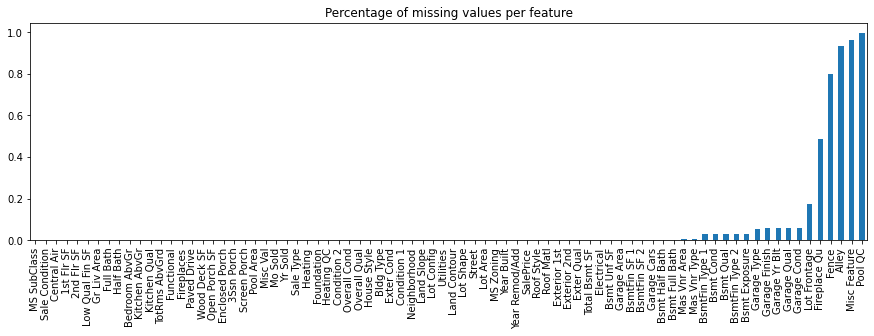

In [420]:
# Investigate the percentage of missing values per feature. 
train_df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature");

In [421]:
# Check a Ordinal feature
train_df["Garage Cond"].value_counts(dropna=False)

TA     2202
NaN     138
Fa       61
Po       14
Gd       13
Ex        2
Name: Garage Cond, dtype: int64

We see that ``NaN`` values as a mining in this case NaN is for No Garage

# Perform feature encoding
Decision: 
---
First I will encode the ordinal so I can fill NaN values that could occur. 

Encoding all Ordinal variables by defining a numerical scale 1 to 5. 
This way, the machine-learning algorithm will have a sense of the relative distances between the categories, which can be useful information.

In [422]:
# Encoding scale 
encoding_Lot_Shape = {"Reg" : 4, "IR1" : 3, "IR2" : 2, "IR3" : 1}

encoding_Utilities =  {"AllPub" : 4, "NoSewr" : 3, "NoSeWa" : 2, "ELO" : 1}	
	
encoding_Land_Slope = {"Gtl" : 3, "Mod" : 2, "Sev" : 1}

encoding_Bsmt_Exposure = {"Gd" : 5, "Av" : 4, "Mn" : 3, "No" : 2, np.nan : 0}

# Note: BsmtFinType1 and BsmtFinType2 have the same scale
encoding_BsmtFinType1 = {
    "GLQ" :	6,
    "ALQ" :	5,
    "BLQ" : 4,
    "Rec" :	3,
    "LwQ" :	2,
    "Unf" :	1,
    np.nan : 0
}


encoding_Electrical = { 
    "SBrkr" : 5,
    "FuseA" : 4,	
    "FuseF"	: 3,
    "FuseP"	: 2,
    "Mix" : 1,
    np.nan : 0
}


encoding_Functional = {
    "Typ" : 8,
    "Min1" : 7,
    "Min2" : 6,
    "Mod" : 5,
    "Maj1" : 4,
    "Maj2" : 3,
    "Sev" : 2,
    "Sal" :	1
}

encoding_Fireplace_Qu = {
    "Ex" : 5,
    "Gd" : 4,
    "TA" : 3,
    "Fa" : 2,
    "Po" : 1,
    np.nan : 0

}

encoding_Garage_Finish = {
    "Fin" :	3,
    "RFn" :	2,
    "Unf" :	1,
    np.nan : 0,
}

encoding_Paved_Drive = {"Y" : 3, "P" : 2, "N" : 1}

encoding_Fence = {"GdPrv" : 5, "MnPrv" : 4, "GdWo" : 3, "MnWw" : 2,	np.nan : 0}

encoding_other = {np.nan : 0,"Po" : 1, "Fa" : 2,"TA" : 3,"Gd" : 4,"Ex" : 5}

ordinal_encoding = {
    "Lot Shape" : encoding_Lot_Shape,
    "Utilities" : encoding_Utilities,
    "Land Slope" : encoding_Land_Slope,
    "Overall Qual" : None,
    "Overall Cond" : None,
    "Bsmt Exposure" : encoding_Bsmt_Exposure,
    "BsmtFin Type 1" : encoding_BsmtFinType1,
    "BsmtFin Type 2" : encoding_BsmtFinType1,
    "Electrical" : encoding_Electrical,
    "Fireplace Qu": encoding_Fireplace_Qu,
    "Garage Finish" : encoding_Garage_Finish,
    "Functional" : encoding_Functional,
    "Paved Drive" : encoding_Paved_Drive,
    "Fence" : encoding_Fence,
    
}


# Encoding ordinal values by numbers
for col in col_ordinal:
    col_encoding = ordinal_encoding.setdefault(col, encoding_other)
    if col_encoding == None:
        continue
    train_df[col] = train_df[col].map(col_encoding)



# Display the change 
train_df[col_ordinal].head()

Lot Shape  Utilities  Land Slope  Overall Qual  Overall Cond  Exter Qual  \
0          3          4           3             7             5           4   
1          4          4           3             6             6           3   
2          4          4           3             4             5           3   
3          3          4           3             5             5           3   
4          3          4           3             7             4           2   

   Exter Cond  Bsmt Qual  Bsmt Cond  Bsmt Exposure  ...  BsmtFin Type 2  \
0           3          4          3              2  ...               1   
1           3          3          3              2  ...               1   
2           3          3          3              2  ...               1   
3           3          3          3              2  ...               1   
4           3          3          3              2  ...               1   

   Electrical  Functional  Fireplace Qu  Garage Finish  Garage Qual  \
0           5           8             3              3            3   
1           5           8             4              1            3   
2           5           8             0              1            3   
3           5           8             4              2            3   
4           3           8             4              1            3   

   Garage Cond  Paved Drive  Pool QC  Fence  
0            3            3        0      0  
1            3            3        0      0  
2            3            3        0      0  
3            3            3        0      0  
4            3            1        0      4  

[5 rows x 21 columns]

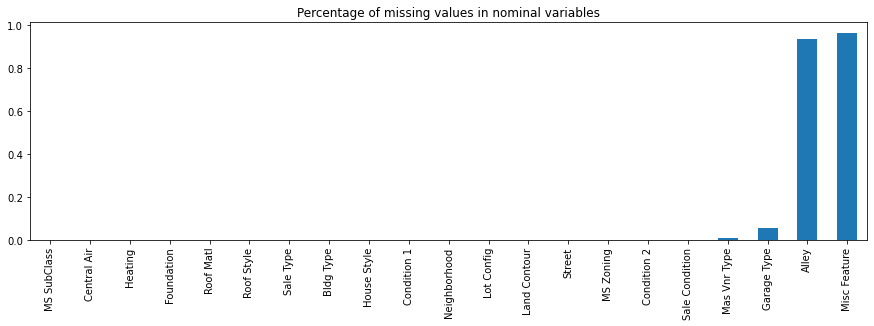

In [423]:
# Investigate the percentage of missing values for nominal variables
train_df[col_normal].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values in nominal variables");

In [424]:
# Display detail of the percentage 
col_normal_with_missing = ["Alley", "Mas Vnr Type", "Garage Type", "Misc Feature"]
train_df[col_normal_with_missing].isna().mean()

Alley           0.932922
Mas Vnr Type    0.008230
Garage Type     0.055967
Misc Feature    0.962963
dtype: float64

Columns with nominal variables NaN values will be fill by they corresponding mining 

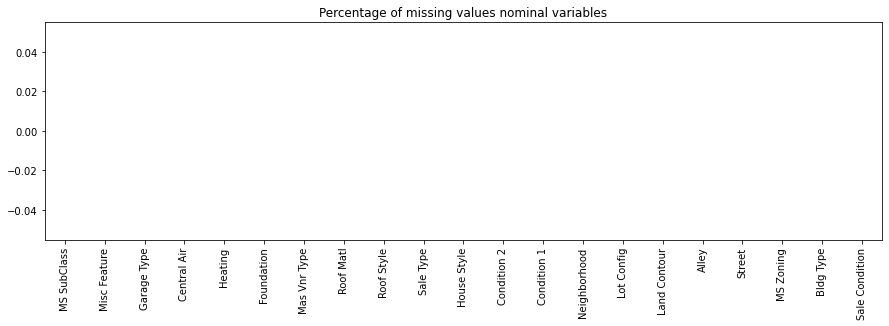

In [425]:
fill_nan = {
    "Alley": "No alley access",
    "Mas Vnr Type": "None",
    "Garage Type": "Garage Type",
    "Misc Feature" : "None"
}

# Fill NaN values by they corresponding mining 
for col in fill_nan:
    train_df[col] = train_df[col].fillna(fill_nan.get(col))

# Display change 
train_df[col_normal].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values nominal variables");

### Investigate the percentage of missing values for continuous variables

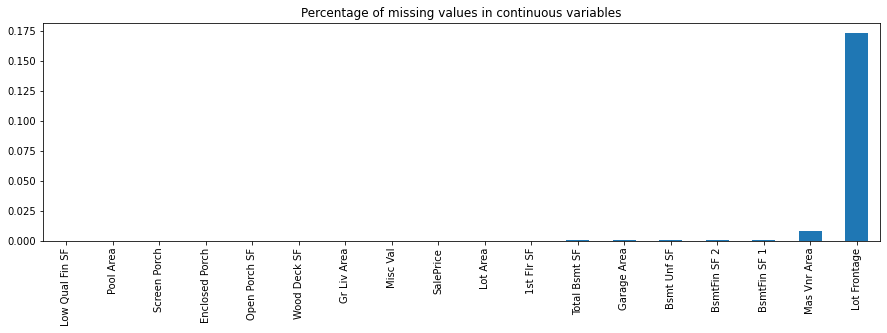

In [426]:
# Investigate the percentage of missing values for continuous variables
train_df[col_continuous].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values in continuous variables");

We see 17% of missing values in `` Lot Frontage``. By loocking a the documentation ``Lot Frontage`` is the linear feet of street connected to property 

### Investigate the frequency of `` Lot Frontage``

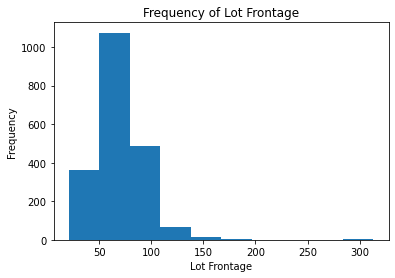

In [427]:
train_df["Lot Frontage"].plot.hist()
plt.title("Frequency of Lot Frontage")
plt.xlabel("Lot Frontage")
plt.show()

In [428]:
# Display the median
train_df["Lot Frontage"].median()

68.0

For ``Lot Frontage`` We see that most of the Nan values are between 60 and 75 with a median at 69.  So I will fill NaN by the median values. 

For the other columns, the percentage of missing values is small and to ovoid introduce bias and uncertainty I will drop NaN values.

In [429]:
# Prop NaN values
col_continuous_with_missing = ["Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "Garage Area"]

# For "Lot Frontage" fill NaN by the median values
train_df["Lot Frontage"] = train_df["Lot Frontage"].fillna(train_df["Lot Frontage"].median())

# Drop other Nan values
train_df = train_df.dropna(subset=col_continuous_with_missing)

# Display the change 
train_df[col_continuous].isna().sum()

Lot Frontage       0
Lot Area           0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64

### Investigate the percentage of missing values for discrete variables

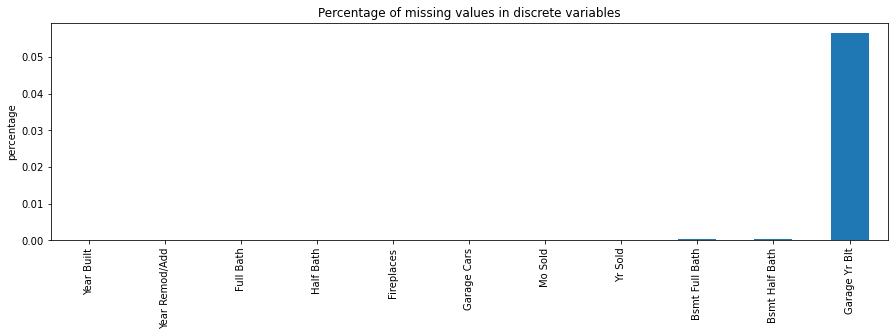

In [430]:
# Investigate the percentage of missing values for discrete variables
train_df[col_discrete].isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values in discrete variables")
plt.ylabel("percentage")
plt.show()

``Garage Yr Blt`` has the highest missing values with only 6%. It's a small percentage of missing values so I will drop them. 

In [431]:
# Drop NaN in discrete variables
col_drop = ["Bsmt Full Bath", "Bsmt Half Bath", "Garage Yr Blt"]
train_df = train_df.dropna(subset=col_drop)


# Display change
train_df[col_discrete].isna().mean()


Year Built        0.0
Year Remod/Add    0.0
Bsmt Full Bath    0.0
Bsmt Half Bath    0.0
Full Bath         0.0
Half Bath         0.0
Fireplaces        0.0
Garage Yr Blt     0.0
Garage Cars       0.0
Mo Sold           0.0
Yr Sold           0.0
dtype: float64

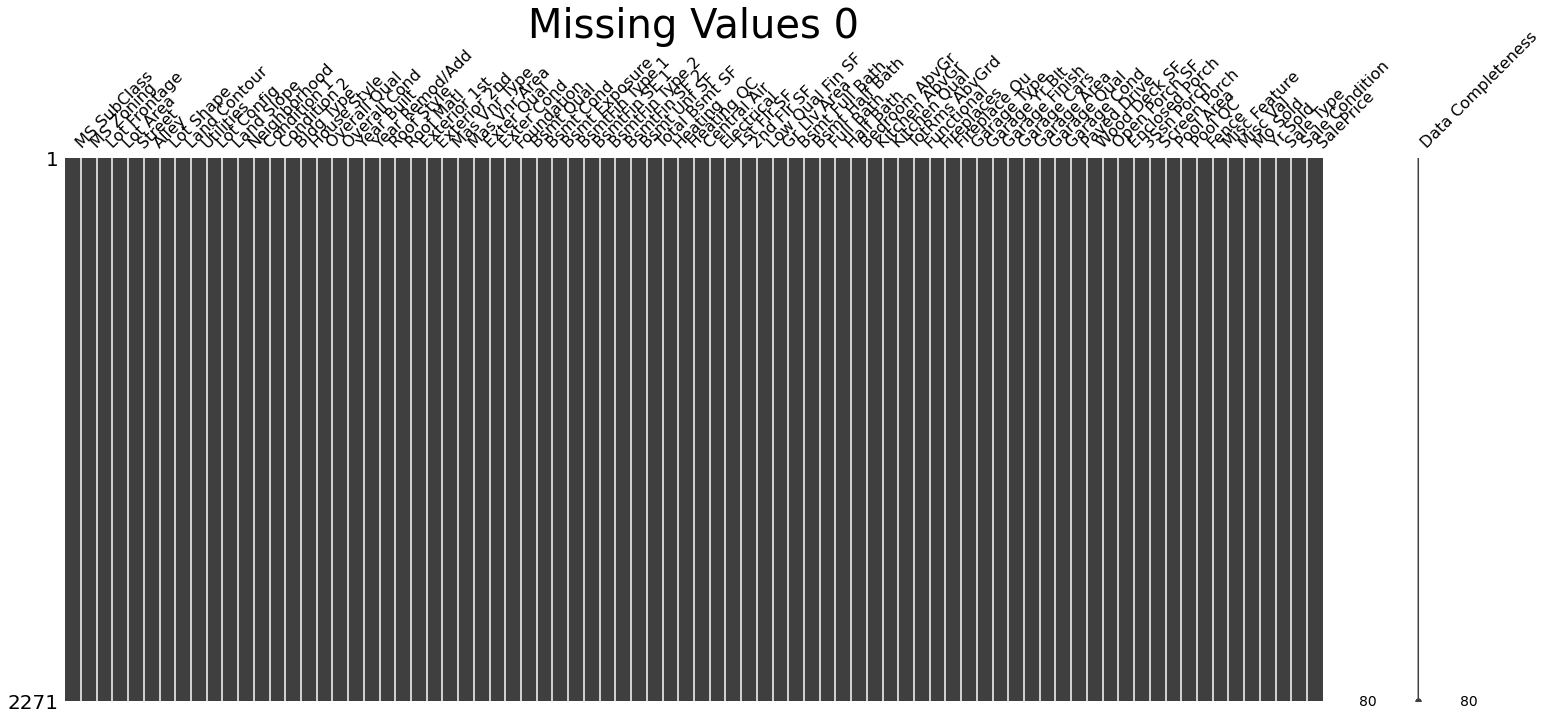

In [432]:
# Check missing values 
msno.matrix(train_df, labels=True)
plt.title("Missing Values {}".format(train_df.isna().sum().sum()), fontsize=40)
plt.show()

### Investigate numerical values

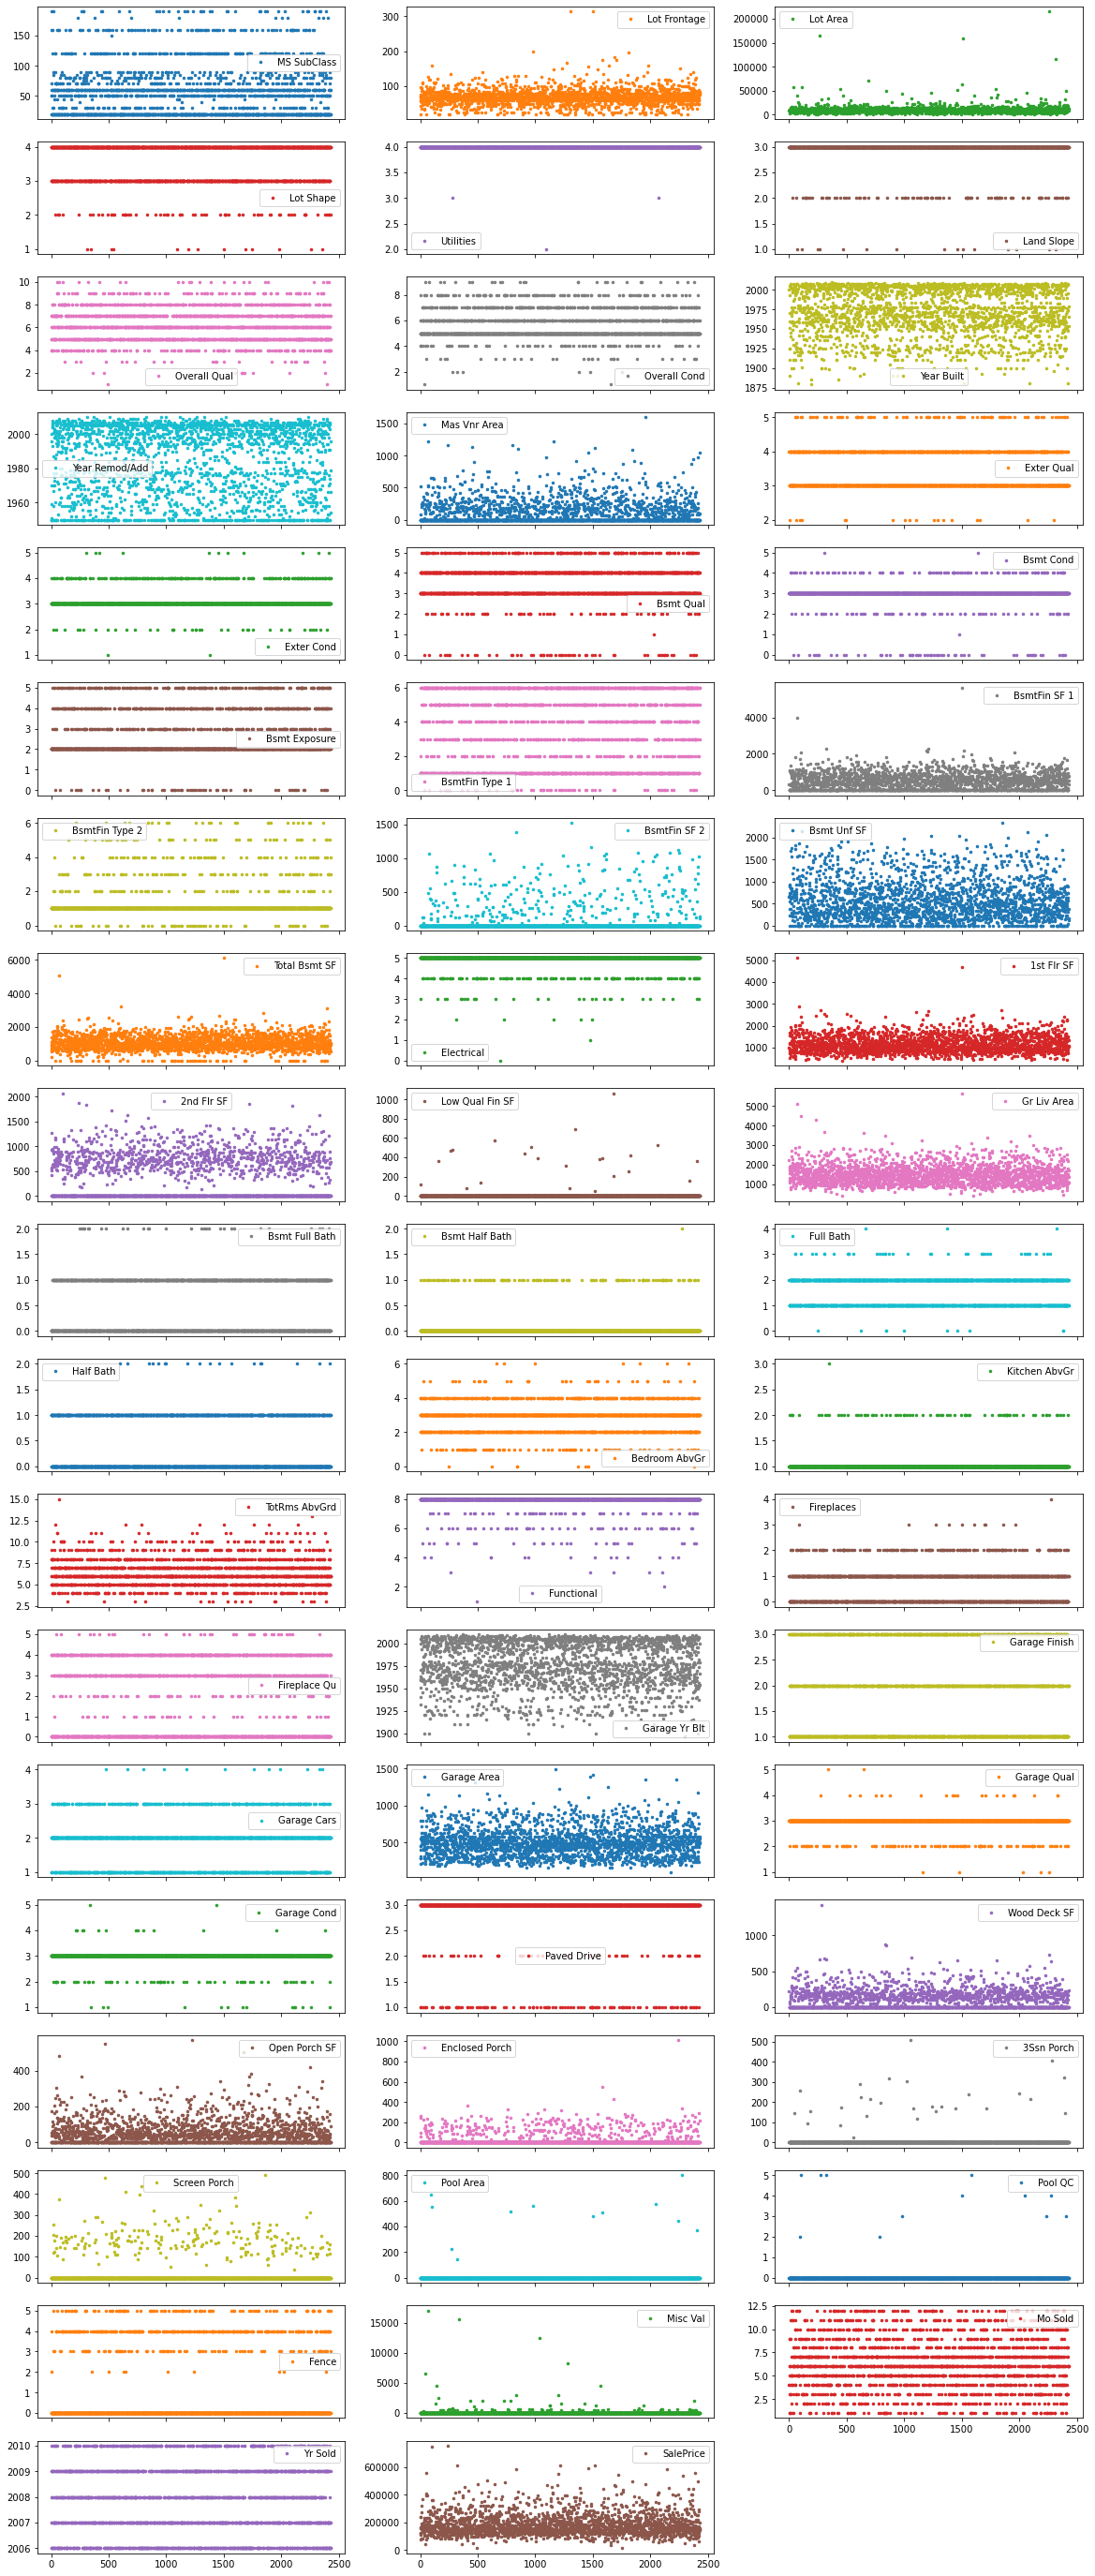

In [433]:
# Plot all numerical values to check outliers
train_df.plot(
    subplots=True,
    marker=".",
    lw=0, 
    layout=(-1, 3),
    figsize=(20, 50),
    markersize=5,

);

### Remove outlier according to the range set

In [434]:
# Set range 
range_values = {
    "Lot Frontage": [200, 320],
    "Lot Area": [40000, 220000],
    "Utilities" : [2, 3],
    "Mas Vnr Area" : [1500, 1600],
    "BsmtFin SF 1": [2700, 6000],
    "BsmtFin SF 2": [1500, 2000],
    "Total Bsmt SF" : [2800, 3000],
    "1st Flr SF" : [2500, 3000],
    "Enclosed Porch" : [600, 1200],
    "Bsmt Half Bath" : [1.70, 2],
    "Low Qual Fin SF" : [600, 1070],
    "Kitchen AbvGr" : [2.70, 3],
    "Wood Deck SF" : [800, 1500],
    "Enclosed Porch" : [450, 555],
    "Misc Val" : [2300, 16000],
    "3Ssn Porch" : [400, 600],
    "Enclosed Porch" : [1000, 1020],
    "Pool Area": [200, 700],
    "Garage Qual" : [4.5, 5],
    "Functional" : [0, 2],
    "Electrical" : [0, 2],
} 

# Remove outlier according to the range set
for col in range_values:
    # Get range numbers
    num = range_values.get(col)
    # locate values that are in the range
    mask = train_df[col].between(num[0], num[1])
    # Drop values outide the sepecified range
    train_df = train_df.drop(mask.loc[mask].index)
 

print("New train_df without outliers shape:", train_df.shape)


New train_df without outliers shape: (2205, 80)


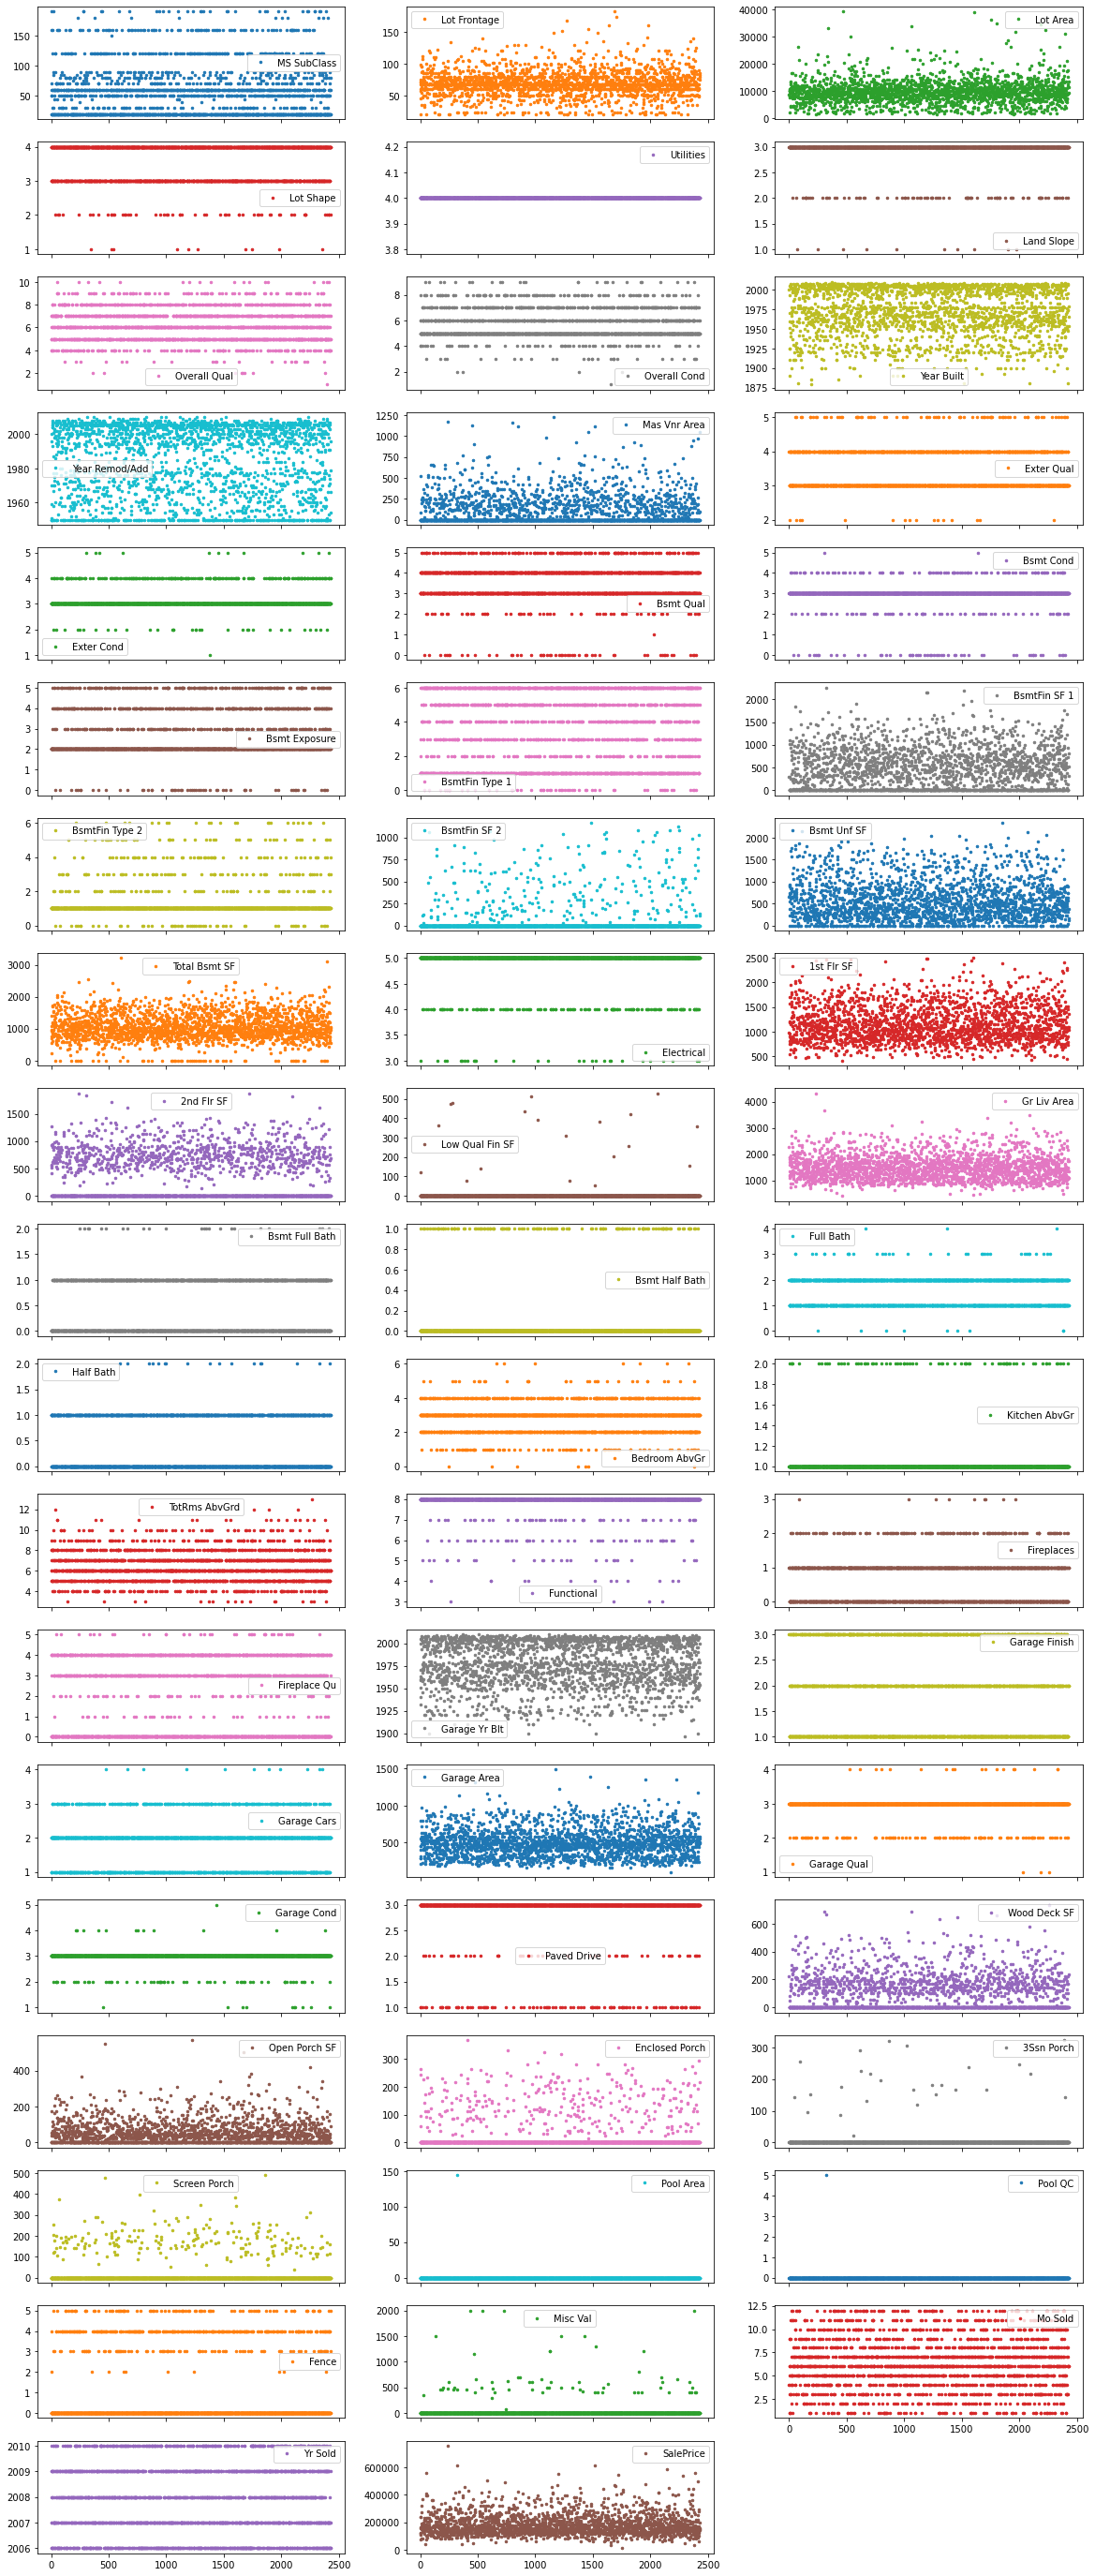

In [435]:
# Plot all numerical values to check outliers
train_df.plot(
    subplots=True,
    marker=".",
    lw=0, 
    layout=(-1, 3),
    figsize=(20, 50),
    markersize=5,

);


### Investigating the relative frequencies of the unique values in columns ``"Pool Area", "Pool QC", "Utilities"``.

In [436]:
# Investigating Utilities 
train_df["Utilities"].value_counts(normalize=True)

4    1.0
Name: Utilities, dtype: float64

In [437]:
# Investigating Pool Area
train_df["Pool Area"].value_counts(normalize=True)

0      0.999546
144    0.000454
Name: Pool Area, dtype: float64

In [438]:
# Investigating Pool QC
train_df["Pool QC"].value_counts(normalize=True)

0    0.999546
5    0.000454
Name: Pool QC, dtype: float64

In [439]:
# Investigating 3Ssn Porch
train_df["3Ssn Porch"].value_counts(normalize=True)[:5]

0      0.988209
168    0.001361
153    0.000907
180    0.000907
144    0.000907
Name: 3Ssn Porch, dtype: float64

We see 98%-100% of these columns contain the same value 0 or 4.

The ``Utilities`` column doesn't contain important information, just if a house as Electricity, Gas, and Water etc. So to save computation time I will remove the column.

The columns ``Pool Area, Pool QC`` contains the information if a house has a pool. We see that 99% of the houses have no pools. I will remove these columns.

For the column ``3Ssn Porch`` It as 98% of the house has no living space available all year long, it doesn't contain important information.  So to save computation time I will remove the column.

In [440]:
# Drop columns not relevant 
train_df = train_df.drop(["Pool Area", "Pool QC", "Utilities", "3Ssn Porch"], axis=1)

### Investagating the correlation pair columns

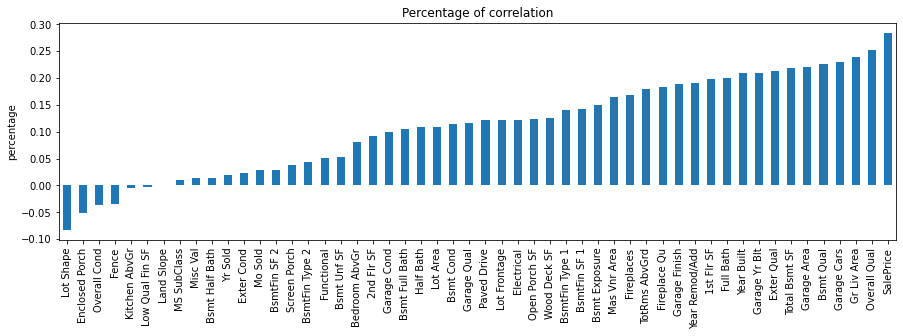

In [441]:
# Investagating the correlation pair columns
train_df.corr().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of correlation")
plt.ylabel("percentage")
plt.show()

- Why are you interested in the mean of the correlation values. What does the percentage of correlation represent and what does it tell us?

We see negative correlation where one variable increases, the other variable decreases, and the correlation coefficient between the two variables is negative.

The percentage of correlation tells us how closely the two variables move together

We see 2 collinear features by looking to the documentation I fond features that have similarities with each other. 

By looking at the documentation
- We see that ``House Style`` and MS SubClass MS have similarities with each other.
- We see that ``BsmtFin SF 1`` and ``BsmtFin SF 2`` are already in  ``Total Bsmt SF`` I will remove the two other features.
- I have a look at ``"Street", "Alley", "Paved Drive" `` they have similarities with each other. To avoid confusion I will keep them.

In [442]:
# Drop House Style, BsmtFin SF 1 and BsmtFin SF 2 
train_df = train_df.drop(["House Style", "BsmtFin SF 1", "BsmtFin SF 2"], axis=1)

In [443]:
# Check "Street", "Alley", "Paved Drive 
# To avoid confusion I will keep them
train_df.loc[:, ["Street", "Alley", "Paved Drive"]]

Street            Alley  Paved Drive
0      Pave  No alley access            3
1      Pave  No alley access            3
2      Pave  No alley access            3
3      Pave  No alley access            3
4      Pave  No alley access            1
...     ...              ...          ...
2424   Pave  No alley access            3
2426   Pave  No alley access            3
2427   Pave  No alley access            3
2428   Pave  No alley access            3
2429   Pave  No alley access            3

[2205 rows x 3 columns]

### Feature engineering

Your analysis should also include feature engineering. Here are a few ideas.

- Create indicator variable ex. year of construction is older than some threshold
- Transformations ex. log-transforms, polynomials

Adding total counts of features to compress the information and removing the original features.


### Plot a histogram of each numerical feature to see the distribution pattern in a separate subplot

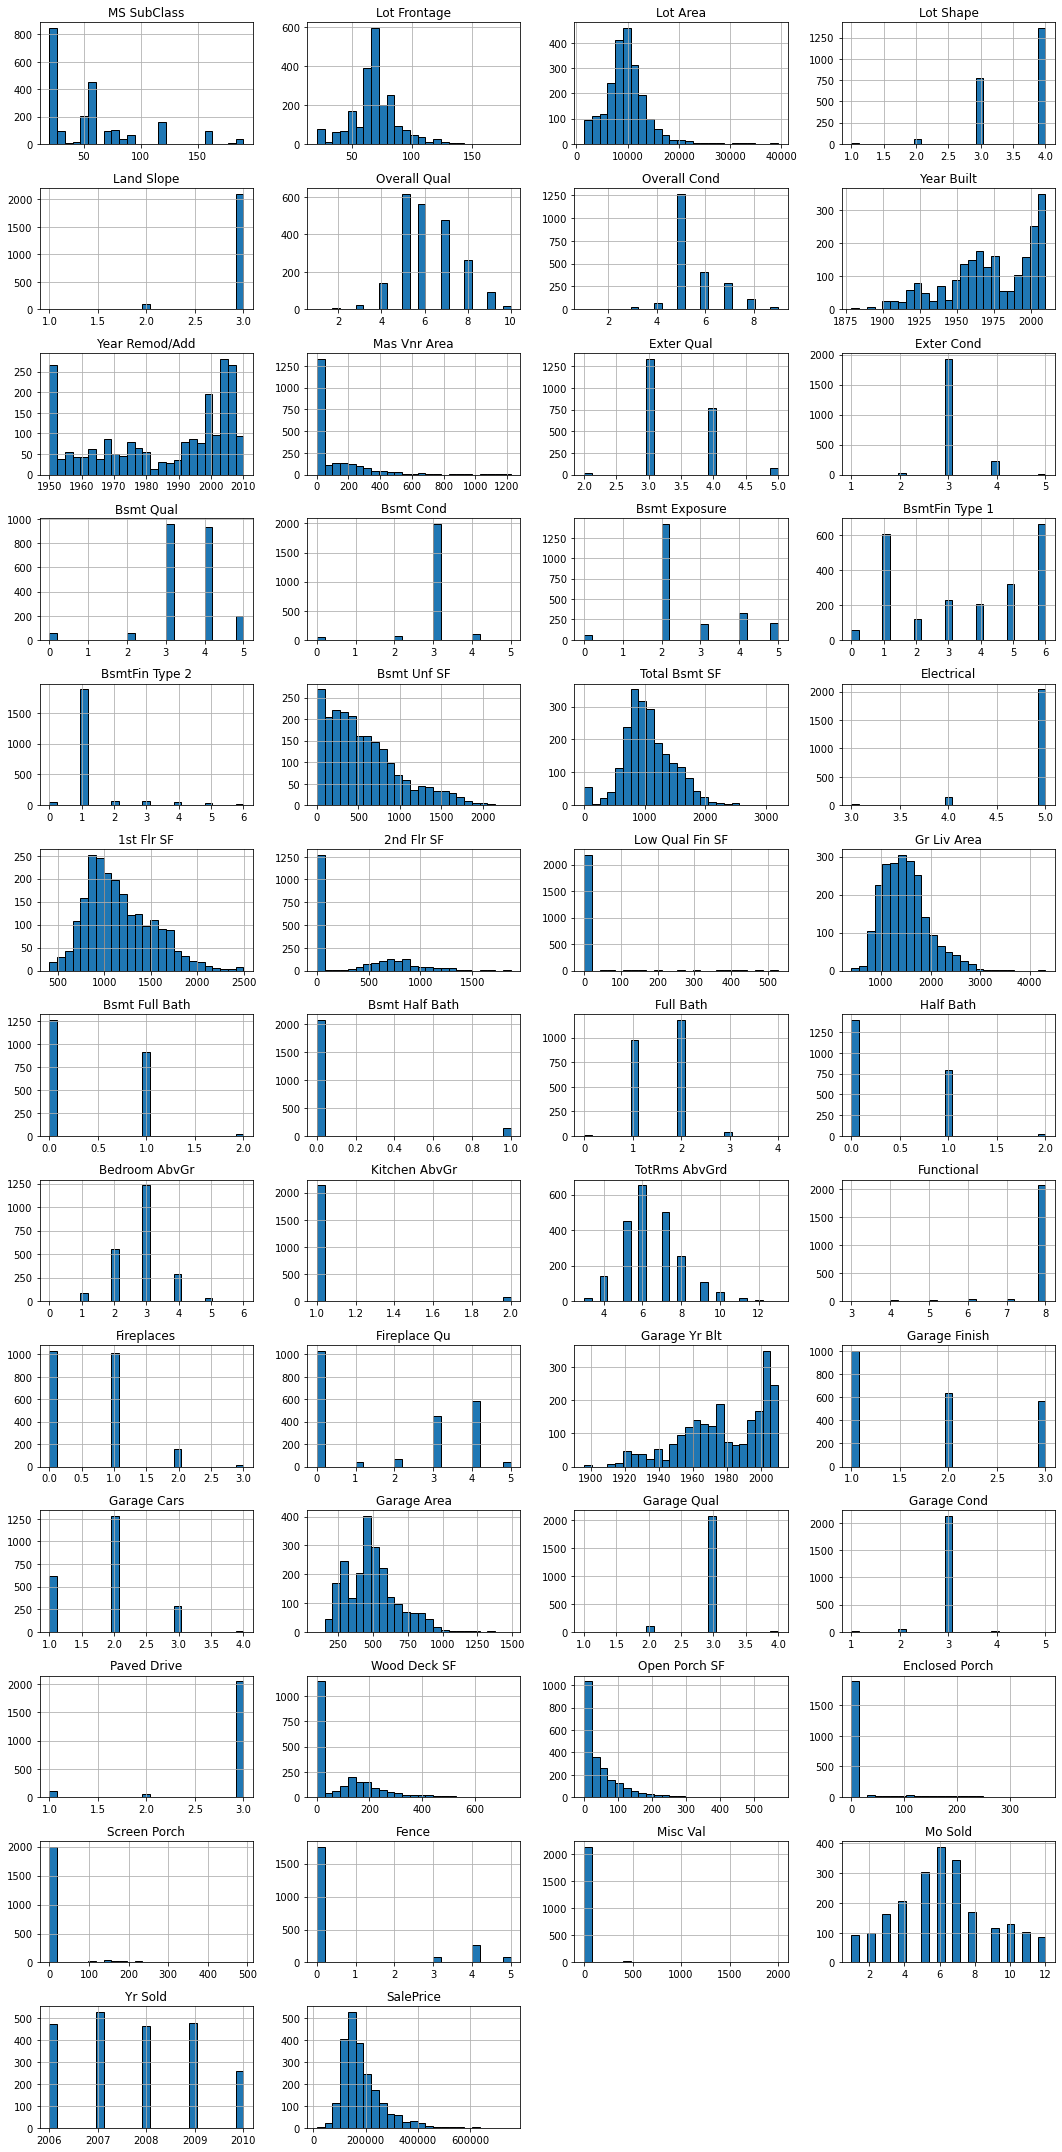

In [444]:
# Plots the histogram for each numerical feature in a separate subplot
train_df.hist(bins=25, figsize=(15, 30), layout=(-1, 4), edgecolor="black")
plt.tight_layout()

By looking at the plots, I will 
- Sum up ``1st Flr SF`` and ``2nd Flr SF`` to ``total Flr SF``
- Create indicator variables for year of construction if values are above the threshold we set 1 and 0 if lower 

###  Sum up 1st Flr SF and 2nd Flr SF to "total Flr SF".

In [445]:
# Sum up 1st Flr SF and 2nd Flr SF to "total Flr SF"
train_df["total Flr SF"] = train_df.loc[:, ["1st Flr SF", "2nd Flr SF"]].sum(axis=1) 
train_df = train_df.drop(["1st Flr SF", "2nd Flr SF"], axis=1)

### Invetigat the ``Year Built`` and the ``Garage Yr Blt``  against ``SalePrice``

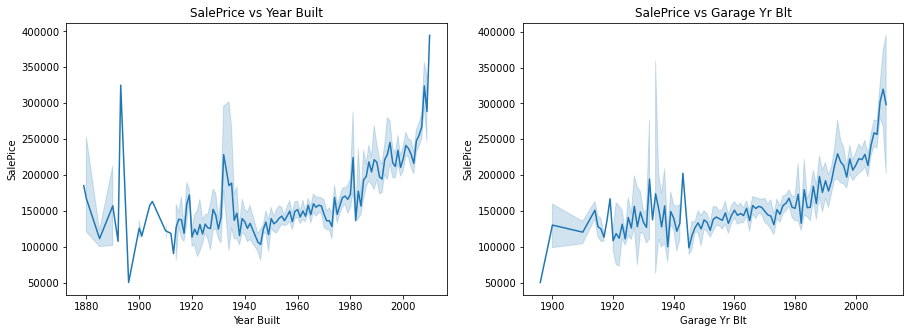

In [446]:
# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

columns = ["Year Built", "Garage Yr Blt"]

for col, ax in zip(columns, axes.ravel()):
    sns.lineplot(x=col, y="SalePrice", data=train_df, ax=ax)
    ax.set(
        title="SalePrice vs {}".format(col),
        xlabel=col,
        ylabel="SalePice"
    )
plt.show()


We see that the values a ranging betwenn 1879 to 2010 I will use ``pd.cut()`` function to bin the year values into 9-year intervals, using the bins argument to specify the intervals and the labels argument to assign a label to each bin. 


In [447]:
# New range
np.arange(1880, 2020, 9)

array([1880, 1889, 1898, 1907, 1916, 1925, 1934, 1943, 1952, 1961, 1970,
       1979, 1988, 1997, 2006, 2015])

In [448]:
# Bin the year values into 9 year intervals
train_df["Year Built intervals"] = pd.cut(train_df["Year Built"], 
                                            bins=range(1880, 2020, 9),
                                            labels=range(1880, 2010, 9))

train_df[train_df["Year Built intervals"].isna()].loc[:, ["Year Built", "Year Built intervals"]]

Year Built Year Built intervals
75          1880                  NaN
192         1879                  NaN
1516        1880                  NaN
2092        1880                  NaN
2419        1880                  NaN

In [449]:
# Year Built intervals as NaN values I will fill them by 1880 
train_df["Year Built intervals"] = train_df["Year Built intervals"].fillna(1880).astype(int)

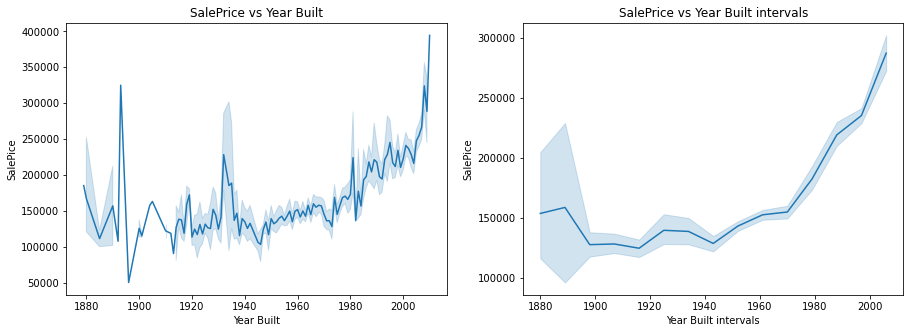

In [450]:
# Plot the change
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

columns = ["Year Built", "Year Built intervals"]

for col, ax in zip(columns, axes.ravel()):
    sns.lineplot(x=col, y="SalePrice", data=train_df, ax=ax)
    ax.set(
        title="SalePrice vs {}".format(col),
        xlabel=col,
        ylabel="SalePice"
    )
plt.show()

# Doing the same for Garage Yr Blt

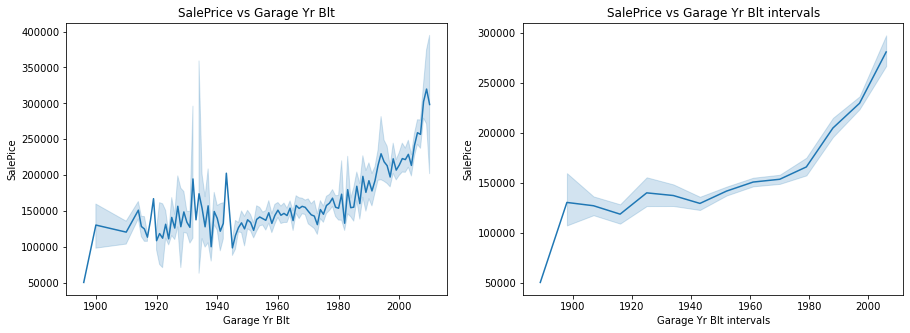

In [451]:
# Bin the year values into 9 year intervals
train_df["Garage Yr Blt intervals"] = pd.cut(train_df["Garage Yr Blt"], 
                                            bins=range(1880, 2020, 9),
                                            labels=range(1880, 2010, 9)).astype(int)

# Plot the change
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

columns = ["Garage Yr Blt", "Garage Yr Blt intervals"]

for col, ax in zip(columns, axes.ravel()):
    sns.lineplot(x=col, y="SalePrice", data=train_df, ax=ax)
    ax.set(
        title="SalePrice vs {}".format(col),
        xlabel=col,
        ylabel="SalePice"
    )
plt.show()

In [452]:
# drop Year Built and Garage Yr Blt
train_df = train_df.drop(["Year Built", "Garage Yr Blt"], axis=1)

# Investigating target value

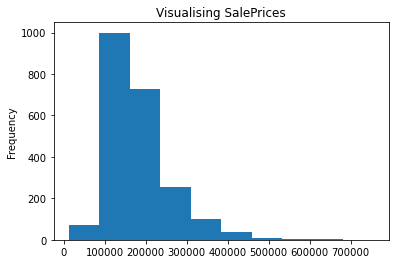

In [453]:
# Plot SalePrices
train_df.SalePrice.plot.hist()
plt.title("Visualising SalePrices")
plt.show()

To avoid building a model that is biased toward more expensive houses, we will apply the logarithm transformation and build a model that predicts the log of the sale price. 

### Finding the best log to use by checking 
- if the data is mainly positive
- if the difference between the minimum and maximum values range is less than three orders of magnitude

In [454]:
# Check train_df.SalePrice is mainly positive
positive_percentage = np.sum(train_df.SalePrice.values > 0) / len(train_df.SalePrice.values) * 100

if positive_percentage > 95:
    print("log10()")
else:
    print("log()")

log10()


In [455]:
# Check orders of magnitude
log10_range = np.log10(np.max(train_df.SalePrice.values)) - np.log10(np.min(train_df.SalePrice.values))

if log10_range < 3:
    print("log10()")
    # Range of values spans less than three orders of magnitude
    # Consider using log10() transformation
else:
    print("log()")

log10()


Decision: 
---
I will use ``log10(x + 1)`` 

The +1 in the transformation ensures that the function can handle values of 0 without returning NaN.

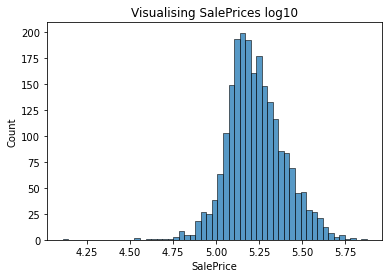

In [456]:
# Transfomr SalePrice using np.log10()
log_sale = np.log10(train_df.SalePrice + 1)

# Plot the transfomation
sns.histplot(log_sale)
plt.title("Visualising SalePrices log10")
plt.show()

To remove outliers I will use interquartile Range IGR its less sensitive to extreme values and works well for the ``SalePirce``.

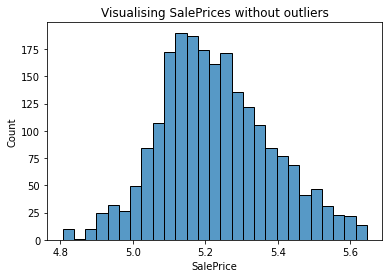

In [457]:
# Calculate IQR
Q1 = log_sale.quantile(0.25)
Q3 = log_sale.quantile(0.75)
IQR = Q3 - Q1

# Calculate lower and upper bounds
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Remove outliers
without_outlires = log_sale[(log_sale > lower_bound) & (log_sale < upper_bound)]

# Plot without outliers
sns.histplot(x=without_outlires)
plt.title("Visualising SalePrices without outliers")
plt.show()

In [458]:
# Save train_df without outliers 
train_df = train_df.loc[without_outlires.index]

# Feature encoding
Your analysis should include the necessary feature encoding steps. The documentation.txt file labels each variable with its type. For categorical ones, it uses the ordinal and nominal classification.

- Ordinal variables - you can order the categories
- Nominal variables - no possible ordering of the categories

The encoding depends on the type of variable and its meaning. For instance, the kitchen quality variable is on a scale from excellent to poor. Hence, it’s an ordinal variable, and you can choose to apply one-hot encoding or define a numerical scale ex. excellent corresponds to 5 and poor to 1. In any case, justify your choices!

I`ve already encodede all the ordinal columnes for the other columns I will just encode them using the ``pd.get_dummies()`` method.

In [459]:
# One-Hot Encode
df_dummies = pd.get_dummies(train_df, drop_first=True)

In [460]:
# Separte X, y
X = df_dummies.drop("SalePrice", axis=1)
y = df_dummies.SalePrice

### Change ``unit8`` to ``int`` for train set

In [461]:
# Change unit8 to int for train set
change_type = X.select_dtypes("uint8").columns

X[change_type] = X[change_type].astype(int)

In [462]:
# Compute the standard deviation of each column
std_dummies = X.std()

# Sort the values and display them
std_dummies.sort_values(ascending=True)


Heating_OthW               0.021467
Exterior 1st_ImStucc       0.021467
Exterior 1st_Stone         0.021467
Mas Vnr Type_CBlock        0.021467
Sale Type_VWD              0.021467
                           ...     
Total Bsmt SF            398.396045
Bsmt Unf SF              440.555873
total Flr SF             445.697850
Gr Liv Area              445.824272
Lot Area                4179.494903
Length: 188, dtype: float64

We see feature that have a standard deviation of 0.021467, it means that all values in that feature are very similar or identical. As a result, that feature does not provide any useful information for modelling and can be considered a constant feature.

Therefore, I will drop these features with a standard deviation of 0.021467 or any other value that is close to zero.

In [463]:
# Find the indices of the constant columns
constant_cols = std_dummies[std_dummies <= 0.022]
print(constant_cols)

# Drop features that have a standard deviation of 0.021467
X = X.drop(constant_cols.index, axis=1) 

Neighborhood_Landmrk    0.021467
Condition 2_PosN        0.021467
Condition 2_RRAn        0.021467
Roof Matl_Membran       0.021467
Roof Matl_Metal         0.021467
Exterior 1st_ImStucc    0.021467
Exterior 1st_Stone      0.021467
Exterior 2nd_CBlock     0.021467
Mas Vnr Type_CBlock     0.021467
Heating_OthW            0.021467
Heating QC_Po           0.021467
Kitchen Qual_Po         0.021467
Sale Type_VWD           0.021467
dtype: float64


In [464]:
# Identify the constant features
constant_features = []

for column in X.columns:
    if X[column].var(ddof=1) == 0:
        constant_features.append(column)

print("Constant features: ", constant_features)
print("Number of constant features:", len(constant_features))


# Remove the constant featured
X = X.drop(constant_features, axis=1)

Constant features:  []
Number of constant features: 0


In [465]:
# Compute rank and condition number
X1 = np.c_[np.ones(X.shape[0]), X]
M = X.shape[1]  # Number of columns
rank = np.linalg.matrix_rank(X1)
cond = np.linalg.cond(X1)
print("Columns {} rank {} collinear {}".format(M, rank, M - rank))
print("Condition number:", cond)

Columns 175 rank 175 collinear 0
Condition number: 1.7502633007010864e+16


We see no collinear columns and the condition number is good.

## Predicting on test data
Now that you have your three models ready, let’s go to the 500 new houses that are unseen by your models. They make your test set. Get the attributes of these houses from house-prices-test.csv and predict their prices using each model and save them in a .csv file.

- Predictions from your simple model - ``predictions-simple-model.csv``
- Predictions from your intermediate model - ``predictions-intermediate-model.csv``
- Predictions from your complex model - ``predictions-complex-model.csv``

Your .csv files must contain 500 rows and 2 columns: the house PID and the predicted price as SalePrice

### First clearing the test data

In [466]:
# Display the first 5 rows of data test
df_test = pd.read_csv("house-prices-test.csv")
df_test.head()


Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0   2217  909279080           50        RL           NaN     11275   Pave   
1    837  907126050           20        RL          65.0      9757   Pave   
2   2397  528144030           60        RL          86.0     11065   Pave   
3   1963  535452060           20        RL          70.0      7000   Pave   
4    306  911202100           50   C (all)          66.0      8712   Pave   

  Alley Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0   NaN       IR1          HLS  ...            0         0     NaN   NaN   
1   NaN       Reg          Low  ...           92         0     NaN   NaN   
2   NaN       IR1          Lvl  ...            0         0     NaN   NaN   
3   NaN       Reg          Lvl  ...            0         0     NaN  MnWw   
4  Pave       Reg          HLS  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  Sale Condition  
0          NaN        0       3    2007        WD           Normal  
1          NaN        0      10    2009        WD           Normal  
2          NaN        0      10    2006        New         Partial  
3          NaN        0       4    2007        WD           Family  
4          NaN        0       1    2010        WD          Abnorml  

[5 rows x 81 columns]

The ``Order`` and ``PID`` variables are identifiers. They are not useful to predict house prices. I will drop them

In [467]:
# Drop Order and PID variable 
df = df_test.drop(["Order", "PID"], axis=1)

In [468]:
# Plot all the test data 
fig, axes = plt.subplots(round(len(df.columns)/4), 4, figsize=(30, 80))

for col, ax in zip(df.columns, axes.ravel()):
    if df[col].dtype in [np.int64, np.float64]: 
        sns.histplot(data=df, x=col, ax=ax)
    else:
        # Show the counts of observations in each categorical
        sns.countplot(data=df, y=col, ax=ax)

plt.tight_layout()
plt.suptitle("Investigate the test data", fontsize=40, y=1.01)
plt.show()

### Investigate the percentage of missing values per feature. 

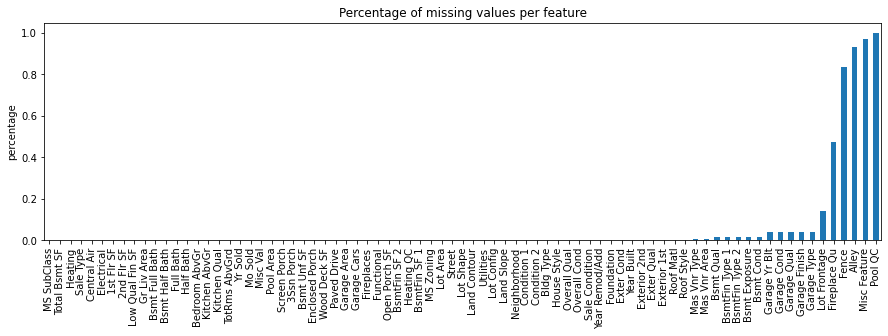

In [ ]:
# Investigate the percentage of missing values per feature. 
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per feature")
plt.ylabel("percentage")
plt.show()

### First I will encode the ordinal so I can fill NaN values that could occur. 

In [ ]:
# Encoding ordinal values by numbers
for col in col_ordinal:
    col_encoding = ordinal_encoding.setdefault(col, encoding_other)
    if col_encoding == None:
        continue
    df[col] = df[col].map(col_encoding)


# Display the change 
df[col_ordinal].head()

Lot Shape  Utilities  Land Slope  Overall Qual  Overall Cond  Exter Qual  \
0          3          4           2             6             7           3   
1          4          4           2             5             7           3   
2          3          4           3             8             5           4   
3          4          4           3             5             7           3   
4          4          4           2             4             7           3   

   Exter Cond  Bsmt Qual  Bsmt Cond  Bsmt Exposure  ...  BsmtFin Type 2  \
0           3          3          3              3  ...               2   
1           4          3          3              2  ...               1   
2           3          4          3              3  ...               1   
3           3          3          3              2  ...               1   
4           3          3          3              3  ...               1   

   Electrical  Functional  Fireplace Qu  Garage Finish  Garage Qual  \
0           5           8             4              1            3   
1           5           8             0              2            3   
2           5           8             4              3            3   
3           5           8             0              2            3   
4           5           8             0              2            3   

   Garage Cond  Paved Drive  Pool QC  Fence  
0            2            3        0      0  
1            3            3        0      0  
2            3            3        0      0  
3            3            3        0      2  
4            3            1        0      0  

[5 rows x 21 columns]

### Columns with nominal variables NaN values will be fill by they corresponding mining 

In [ ]:
# Fill NaN values by they corresponding mining 
for col in fill_nan:
    df[col] = df[col].fillna(fill_nan.get(col))

### For continuous variables filling by thy median to conserve the rows

In [ ]:
# Fill NaN values by the median 
col_continous_with_missing = [
    "Mas Vnr Area", 
    #"BsmtFin SF 1", will be drop
    #"BsmtFin SF 2", will be drop
    "Bsmt Unf SF", 
    "Total Bsmt SF", 
    "Garage Area", 
    "Lot Frontage"
    ]

# Fill NaN values by the median
for col in col_continous_with_missing:
    df[col] = df[col].fillna(train_df[col].median())

### For discrete variables variables filling by thy median to conserve the rows

- you are calculating ``df["Garage Yr Blt"].median()`` where ``df`` is the test data. We should never construct statistical values from the test data and apply them to the test data. The median sale price may have changed over time as the whole market has shifted. Instead we should always use the statistical info from the training data for imputing missing values, etc.

In [ ]:
# Drop NaN in discrete variables
""" df["Garage Yr Blt"] =  df["Garage Yr Blt"].fillna(train_df["Garage Yr Blt"].median()) """

' df["Garage Yr Blt"] =  df["Garage Yr Blt"].fillna(train_df["Garage Yr Blt"].median()) '

### Drop columns not relevant ``"Pool Area", "Pool QC", "Utilities"``.

We see 100% of this column contains the same value 4 or 0 .

The ``Utilities`` column doesn't contain important information just if a house as Electricity, Gas, and Water etc.  So to save computation time I will remove the column.

The columns ``Pool Area, Pool QC`` contains the information if a house has a pool. We see that 100% of the houses have no pools. I will remove these columns.

In [ ]:
# Drop columns not relevant 
df = df.drop(["Pool Area", "Pool QC", "Utilities", "3Ssn Porch"], axis=1)

We see 2 collinear features by looking to the documentation I fond features that have similarities with each other. 

By looking at the documentation
- We see that ``House Style`` and MS SubClass MS have similarities with each other.
- We see that ``BsmtFin SF 1`` and ``BsmtFin SF 2`` are already in  ``Total Bsmt SF`` I will remove the two other features.
- I have a look at ``"Street", "Alley", "Paved Drive" `` they have similarities with each other. To avoid confusion I will keep them.

In [ ]:
# Drop House Style, BsmtFin SF 1 and BsmtFin SF 2 
df = df.drop(["House Style", "BsmtFin SF 1", "BsmtFin SF 2"], axis=1)

# Bin the year values into 9-year intervals

In [ ]:
# Check Nan values for Garage Yr Blt
df[df["Garage Yr Blt"].isna()].loc[:, ["Year Built", "Garage Yr Blt"]]

Year Built  Garage Yr Blt
6          1900            NaN
58         1970            NaN
62         1946            NaN
63         1968            NaN
81         1925            NaN
101        1955            NaN
102        1951            NaN
184        1941            NaN
199        1961            NaN
212        1959            NaN
233        1985            NaN
237        1970            NaN
301        1926            NaN
303        1919            NaN
321        1955            NaN
337        1920            NaN
448        1967            NaN
453        1949            NaN
457        1872            NaN
465        1941            NaN
482        1910            NaN

In [ ]:
# I will fill NaN by the Year Built 
df["Garage Yr Blt"] = df["Garage Yr Blt"].fillna(df["Year Built"])

# Bin the year values into 9 year intervals

In [ ]:
# Bin the Year Built values into 9 year intervals
df["Year Built intervals"] = pd.cut(df["Year Built"], 
                                            bins=range(1880, 2020, 9),
                                            labels=range(1880, 2010, 9))

# Bin the year values into 9 year intervals
df["Garage Yr Blt intervals"] = pd.cut(df["Garage Yr Blt"], 
                                            bins=range(1880, 2020, 9),
                                            labels=range(1880, 2010, 9))

In [ ]:
# Check for nan values in Year Built intervals
df[df["Year Built intervals"].isna()].loc[:, ["Year Built", "Year Built intervals"]]

Year Built Year Built intervals
283        1880                  NaN
457        1872                  NaN

In [ ]:
# I will simply fill NaN value by the nearest bin in the case 1880 
df["Year Built intervals"] = df["Year Built intervals"].fillna(1880).astype(int)

In [ ]:
# Check for nan values in Garage Yr Blt intervals
df[df["Garage Yr Blt intervals"].isna()].loc[:, ["Year Built intervals", "Garage Yr Blt", "Garage Yr Blt intervals"]]

Year Built intervals  Garage Yr Blt Garage Yr Blt intervals
457                  1880         1872.0                     NaN

In [ ]:
# I will simply fill NaN value by the nearest bin in thso case 1880
df["Garage Yr Blt intervals"] = df["Garage Yr Blt intervals"].fillna(1880).astype(int)

# Drop Year Built and Garage Yr Blt

In [ ]:
# Drop Year Built and Garage Yr Blt
df = df.drop(["Year Built", "Garage Yr Blt"], axis=1)

### Verify that we have no NaN values

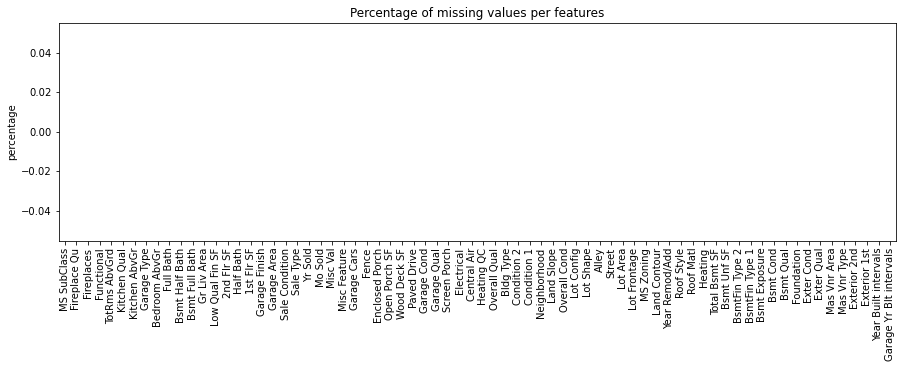

In [ ]:
# Investigate the percentage of missing values per feature. 
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4), title="Percentage of missing values per features")
plt.ylabel("percentage")
plt.show()

### Adding total counts of features to compress the information and removing the original features.

In [ ]:
# Sum up 1st Flr SF and 2nd Flr SF to "total Flr SF"
df["total Flr SF"] = df.loc[:, ["1st Flr SF", "2nd Flr SF"]].sum(axis=1) 
df = df.drop(["1st Flr SF", "2nd Flr SF"], axis=1)

# One-Hot Encode

In [ ]:
# One-Hot Encode
X_test = pd.get_dummies(df, drop_first=True)

## Change dtype ``uint8`` to ``int``

In [ ]:
# Change unit8 to int for test set
change_type = X_test.select_dtypes("uint8").columns

X_test[change_type] = X_test[change_type].astype(int)

# Create a new category for unseen values

In [ ]:
# Align the test set with the training set to ensure they have the same columns
X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

Splitting data
---
You should split the data into training and validation sets (e.g. 60-40 split). You will use the training set for fitting the models and the validation set for evaluating the models and tuning hyperparameters.

>As mention above I will $log10(y +1)$ the target values

In [ ]:
# Spliting data
X_tr, X_val, y_tr, y_val = train_test_split(X, np.log10(y + 1), test_size=0.4, random_state=0)

Model fitting
---
Your analysis should include an appropriate baseline and evaluate three different models ranging in complexity

- A baseline that entails no modeling, and supposedly should be beaten by the three models
- A simple model with two variables (three with the target variable)
An intermediate model (between 10 and 20 variables)
- A complex model with all variables


The number of variables is only given as an indication, it’s not a strict range. Also, it corresponds to the variables count before one-hot encoding. For the simple and intermediate models, you can choose the variables. You are free to choose your preferred approach for this variable selection step, but you should include a short comment to explain your choice.

Regularization
---
Your analysis should include regularization for the complex model.

Briefly explain the objective of regularization, and how it will make the complex model different from other models
Tune regularization strength with grid search
Plot the training and validation curves
Discuss what you observe in the plot, e.g. potential overfitting


The objective of regularisation is to prevent overfitting in a statistical model by adding a penalty term for the loss function. I'm using the L2 penalty in Ridge regression. 

# Fit the different regression

I will use ``SelectKBest`` method to elect the features according to the __k highest__ score and setting ``score_func`` parameter to ``mutual_info_regression`` to calculate how much a given feature can explain the target.

Identifying and removing constant features, which can cause issues in models and reduce their performance.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler

# Setup each regression
simple_model =  Pipeline([("v1", SelectKBest(score_func=mutual_info_regression, k=2)), ("lr", LinearRegression())])
intermediate_model =  Pipeline([("v2", SelectKBest(score_func=mutual_info_regression, k=20)), ("lr", LinearRegression())])
complex_model = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1))])

# Fit models
simple_model.fit(X_tr, y_tr)
intermediate_model.fit(X_tr, y_tr)
complex_model.fit(X_tr, y_tr)

# Save simple and intermediate results
mea_simple = MAE(10 ** y_val -1 , 10 ** simple_model.predict(X_val) -1)
mea_intermediate = MAE(10 ** y_val -1 , 10 ** intermediate_model.predict(X_val) -1)

# Display the results
print("MAE for simple linear regression: {:.3f}$".format(mea_simple))
print("MAE for intermediate linear regression: {:.3f}$".format(mea_intermediate))
print("MAE for all features with ridge regression: {:.3f}$".format(MAE(10 ** y_val -1 , 10 ** complex_model.predict(X_val) -1)))

MAE for simple linear regression: 23744.386$
MAE for intermediate linear regression: 16367.520$
MAE for all features with ridge regression: 13232.416$


## Grid search
- Tune regularization strength with grid search

In [ ]:
from sklearn.metrics import mean_squared_error as MSE
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(0, 10, num=20):
    # Fit the pipeline
    complex_model.set_params(ridge__alpha=alpha)
    complex_model.fit(X_tr, y_tr)

    # Save model and its performance on the train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": MAE(10 ** y_tr -1 , 10 ** complex_model.predict(X_tr) - 1),
            "train_mse": MSE(10 ** y_tr -1 , 10 ** complex_model.predict(X_tr) - 1),
            "val_mae": MAE(10 ** y_val -1 , 10 ** complex_model.predict(X_val) - 1),
            "val_mse": MSE(10 ** y_val -1 , 10 ** complex_model.predict(X_val) - 1),
        }
    )

# Convert results to DataFrame
df_results = pd.DataFrame(gs_results)
# Find the best alpha 
best_alpha = df_results.loc[df_results["val_mse"].idxmin()]

# Print best alpha
print("Best alpha: {:.1e}".format(best_alpha["alpha"]))
print("Best MAE result: {:.1f}$".format(best_alpha["val_mae"]))
print("Best MSE result: {:.1f}$".format(best_alpha["val_mse"]))

Best alpha: 3.8e+01
Best MAE result: 13200.2$
Best MSE result: 367323537.6$


- Plot the training and validation curves


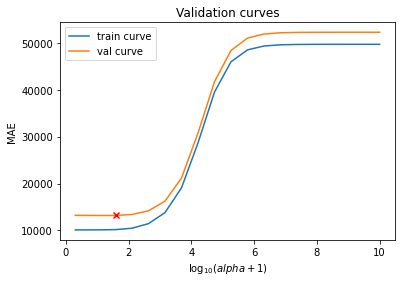

In [ ]:
# Plot the validation curves 
plt.plot(np.log10(df_results["alpha"] +1), df_results["train_mae"], label="train curve")
plt.plot(np.log10(df_results["alpha"] +1), df_results["val_mae"], label="val curve")
plt.scatter(np.log10(best_alpha["alpha"] +1), df_results["val_mae"].min(), marker="x", c="red", zorder=10)
plt.title("Validation curves")
plt.xlabel("$\log_{10}(alpha +1)$")
plt.ylabel("MAE")
plt.legend()
plt.show()

- Discuss what you observe in the plot, e.g. potential overfitting

- The optimal range of alpha values seems to be around 1.6, where we get the best validation score
- The model is overfitting in general when alpha is smaller than the best alpha 
- The model starts underfitting when alpha is larger than 2 as training and validation scores agree but the model performs worse than for other alpha values.

### Update alpha parameter for ridge regression
Change alpha paramater to compute the best  ridge model and compute the new predition


In [ ]:
# Update alpha parameter for ridge regression
complex_model.set_params(ridge__alpha=best_alpha["alpha"])

# Fit Ridge model with the updated alpha parameter
complex_model.fit(X_tr, y_tr)

# Calculate MAE on validation set
mea_complex = MAE(10 ** y_val -1, 10 ** complex_model.predict(X_val) -1)

# Print the MAE on validation set
print("Validation MAE with best alpha: {:.4f}".format(mea_complex))

Validation MAE with best alpha: 13200.1697


Computing the $R^2$ coefficient to measure how well-observed outcomes are replicated by the model.

In [ ]:
# Compute R^2 score for each models
print("R^2 score for simple model: {:.2f}".format(simple_model.score(X_val, y_val)))
print("R^2 score for intermediate model: {:.2f}".format(intermediate_model.score(X_val, y_val)))
print("R^2 score for complex model: {:.2f}".format(complex_model.score(X_val, y_val)))

R^2 score for simple model: 0.77
R^2 score for intermediate model: 0.89
R^2 score for complex model: 0.92


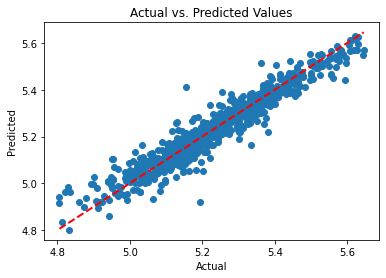

In [ ]:
# Plot the predicted values against the actual values for the validation set
plt.scatter(y_val, complex_model.predict(X_val))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--', color='red', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values')
plt.show()

# Comparing models

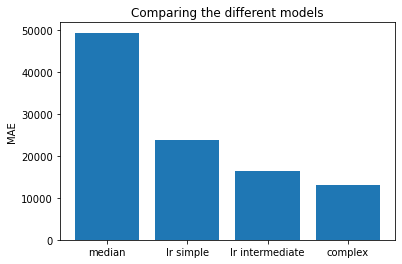

In [ ]:
# Compute baseline
baseline = np.mean(np.abs((10 ** y_tr -1) - (10 ** np.median(y_val) -1)))

# Plot
mea_values = [baseline, mea_simple, mea_intermediate, mea_complex]
titles = ["median", "lr simple", "lr intermediate", "complex"]

plt.bar(titles, mea_values)
plt.title("Comparing the different models")
plt.ylabel("MAE")
plt.show()


# For each model, compute 500 predictions from the test set

- Predictions from your simple model - ``predictions-simple-model.csv``
- Predictions from your intermediate model - ``predictions-intermediate-model.csv``
- Predictions from your complex model - ``predictions-complex-model.csv``

In [ ]:
# Define a function to transfom the test data
def predict_price(model, X_te, df):
    # Predict SalePrice using the model and convert back to original scale
    df["SalePrice"] = 10 ** model.predict(X_te) - 1
    # Select the PID and SalePrice columns
    df = df.loc[:, ["PID", "SalePrice"]]
    return df

simple_model = predict_price(simple_model, X_test, df_test.copy())
intermediate_model = predict_price(intermediate_model, X_test, df_test.copy())
complex_model = predict_price(complex_model, X_test, df_test.copy())

# Save prediction in separate csv file

In [ ]:
# Save prediction in separate csv file
simple_model.to_csv("predictions-simple-model.csv", index=False)
intermediate_model.to_csv("predictions-intermediate-model.csv", index=False)
complex_model.to_csv("predictions-complex-model.csv", index=False)

In [ ]:
simple_model

PID      SalePrice
0    909279080  192295.666911
1    907126050  122053.570189
2    528144030  262602.727438
3    535452060  127356.953102
4    911202100  110066.427687
..         ...            ...
495  905378040  106674.185811
496  533252020  152590.422625
497  527127100  309107.049355
498  906340120  237511.452074
499  902427180  116902.501329

[500 rows x 2 columns]

In [ ]:
intermediate_model

PID      SalePrice
0    909279080  168716.294864
1    907126050  142480.329412
2    528144030  258372.550195
3    535452060  131791.791207
4    911202100  100632.921702
..         ...            ...
495  905378040  142898.226193
496  533252020  170542.768545
497  527127100  336652.729056
498  906340120  253103.322843
499  902427180  109477.836556

[500 rows x 2 columns]

In [ ]:
complex_model

PID      SalePrice
0    909279080  205056.943200
1    907126050  156402.662714
2    528144030  282340.767989
3    535452060  126363.186985
4    911202100  103508.787658
..         ...            ...
495  905378040  132808.646906
496  533252020  169074.407851
497  527127100  375650.655273
498  906340120  264347.967825
499  902427180  113203.789476

[500 rows x 2 columns]